# <font size =8>Graph Embeddings
<font size=4> Graph embedding is an approach that is used to transform nodes, edges, and their features into vector space (a lower dimension) whilst maximally preserving properties like graph structure and information.

# <font color=green> DeepWalk (Random-Walk + Word2Vec)

<font size=4> It introduces for the first time the concept of Random walk for embedding generation. Basically, a random walk is a way of converting a graph into a sequence of nodes for then training a Word2Vec model. Basically, for each node in the graph, the model generates a random path of nodes connected. Once we have these random paths of nodes it trains a Word2Vec (skip-gram) model to obtain the node embeddings. <br>
 
<font size=4> DeepWalk implementation - https://github.com/prateekjoshi565/DeepWalk, http://www.perozzi.net/projects/deepwalk/

# <font color = green> Node2Vec (Mixed DFS and BFS)
<font size=4> Node2Vec uses some of the ideas presented by Deepwalk but goes a step deeper. It uses a combination of the algorithms DFS and BFS to extract the random walks. This combination of algorithms is controlled by two parameters P (return parameter) and Q (in-out parameter). <br>

<font size=4> Basically, if P is large the random walks will be large, so it does exploration and if P is small we stay locally. Similar but opposite behaviour happens with Q, if Q is small it is going to do exploration and if Q is large it is going to stay locally. More details can be found in the original paper.<br>

<font size=4> Node2Vec implementation - https://github.com/eliorc/node2vec, https://github.com/aditya-grover/node2vec

# Experiment
<font size=5> Dataset: karate.edgelist <br>
    
<b>Reference <br>
[1] https://www.kaggle.com/code/shakshisharma/graph-embeddings-deepwalk-and-node2vec/notebook <br>
[2] https://www.geeksforgeeks.org/deepwalk-algorithm/
    

# <font color=Blue>Part 1. Implementation of DeepWalk

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec

# load the classic dataset
edge_list = pd.read_csv("./data/karate.edgelist", sep = ' ', header = None)
edge_list.head()

,0,1
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [2]:
# Rename the data columns
edge_list.rename(columns = {0:'source', 1: 'target'}, inplace = True)
edge_list.head()

,source,target
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [3]:
# convert integers into string
edge_list = edge_list.applymap(str)
edge_list.head()

,source,target
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


# Creation of graph

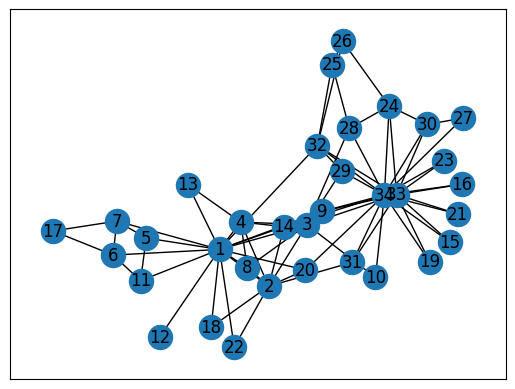

In [4]:
# create undirected graph from the edgelist
G=nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.Graph())
nx.draw_networkx(G)

# Create Embeddings with Deep Walk

<font size=4> Option 1: Use karateclub DeepWalk packages <br>
<font size=4> Option 2: Use a random walk function + gensim.models.Word2Vec as shown in reference <br>

<font size=4 color=red> Option 1 is quick for creating embedding easily. Option 2 is for more flexible tuning and getting parameters of Word2Vec models. I choose option 2 as it have more parameters to return and visulize !

# Use a random walk function + gensim.models.Word2Vec

In [5]:
# function to generate random walk sequences of nodes for a particular node
def get_random_walk(node, walk_length):
    # initialization
    random_walk_length = [node]
    
    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):
        # list of neighbors
        neighbors = list(G.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then donot add them as new neighbors
        neighbors = list(set(neighbors) - set(random_walk_length))    
        if len(neighbors) == 0:
            break
        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor
        
    return random_walk_length

In [6]:
# calculate random walks for every node in the Graph
all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 40))

print ("Example of random_walks:", random_walks[0])

# train word2vec model
deep_walk_model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )

deep_walk_model.build_vocab(random_walks, progress_per=2)
deep_walk_model.train(random_walks, total_examples = deep_walk_model.corpus_count, epochs=20, report_delay=1)



100%|████████████████████████████████████████| 34/34 [00:00<00:00, 14371.29it/s]

Example of random_walks: ['1', '13', '4', '8', '2', '3', '29', '34', '28', '24', '30', '27']


(6969, 33000)

In [7]:
# Visulize most similar nodes to node '1'
for node, _ in deep_walk_model.wv.most_similar('1'):
    print((node, _))

('18', 0.9986628293991089)
('14', 0.9985700845718384)
('12', 0.9983541965484619)
('16', 0.9983283281326294)
('19', 0.9983076453208923)
('21', 0.998251736164093)
('2', 0.9981476664543152)
('8', 0.9980818033218384)
('15', 0.9980634450912476)
('31', 0.9980387091636658)


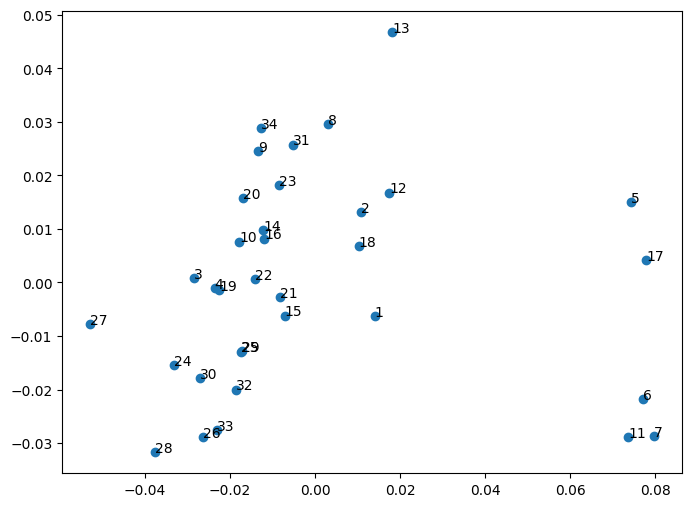

In [8]:
def plot_nodes(model, word_list):
    X = model.wv[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(8,6))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()
numbers = list(G.nodes)
plot_nodes(deep_walk_model, numbers)


# <font color=Blue>Part 2. Implementation of Node2Vec

In [9]:
# Setting of node2vec
node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=100, workers=2)
walks = node2vec.walks
print("Example of Walks:", walks[0])

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Example of Walks: ['2', '4', '3', '2', '31', '33', '32', '26', '24', '34', '10', '3', '1', '13', '1', '7', '1', '7', '6', '11', '6', '1', '4', '8', '2', '3', '4', '13', '4', '14', '34', '10', '34', '21', '34', '33', '31', '2', '22', '1']


Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 425.25it/s]


In [10]:
# Train the model
Node2Vec_model = node2vec.fit(window=10, min_count=1)


In [11]:
# Find most similar nodes to node '1'
for node, _ in Node2Vec_model.wv.most_similar('1'):
    print((node, _))

('5', 0.7959527373313904)
('12', 0.7749162912368774)
('18', 0.7706347703933716)
('7', 0.7670203447341919)
('6', 0.7393041849136353)
('17', 0.7299997806549072)
('11', 0.7261362671852112)
('22', 0.7224041223526001)
('8', 0.7197101712226868)
('4', 0.7184971570968628)


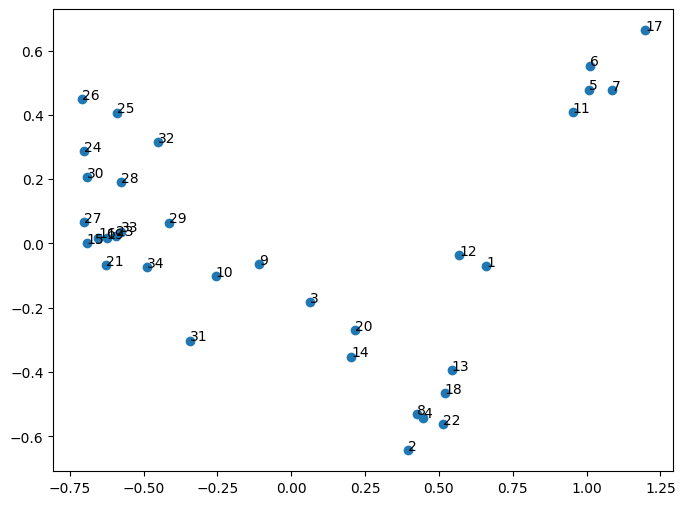

In [12]:
numbers = list(G.nodes)
plot_nodes(Node2Vec_model, numbers)

# Visulization of K-Cluster with Both Embeddings

In [13]:
from sklearn.cluster import KMeans
import numpy as np

def plot_nodes_with_cluster (model, word_list, n_clusters, title="Clusters of Embedding"):
    X = model.wv[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    # fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    
    plt.figure(figsize=(8,6))
    # create a scatter plot of the projection
    scatter = plt.scatter(result[:, 0], result[:, 1], c=labels, cmap='viridis')
    
    # adding legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    
    plt.title(title)
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()


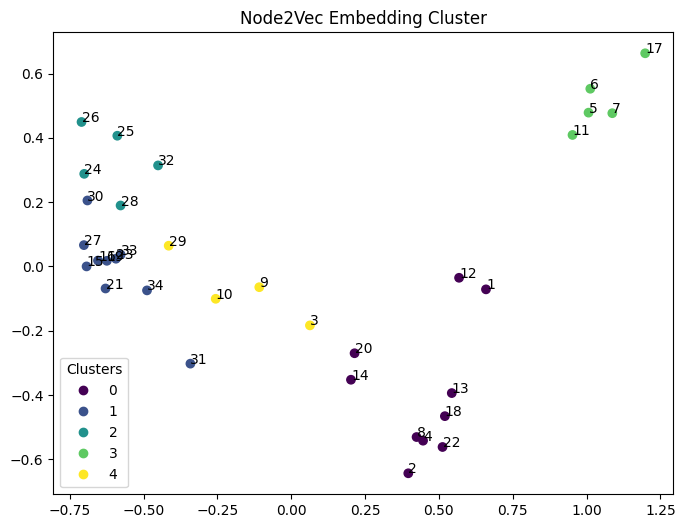

In [14]:
numbers = list(G.nodes)
plot_nodes_with_cluster(Node2Vec_model, numbers, 5, "Node2Vec Embedding Cluster")

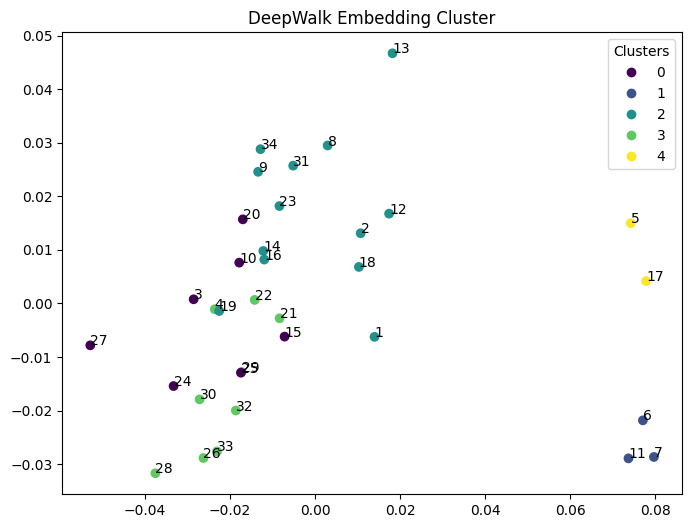

In [15]:
numbers = list(G.nodes)
plot_nodes_with_cluster(deep_walk_model, numbers, 5, "DeepWalk Embedding Cluster")

# Thoughts about embeddings

<font size=4> Node2Vec can be considered as special edition of deepwalk and provides a flexible approach to the random walk by introducing two parameters, p and q, which guide the exploration strategy. <br>
    
<font size=4 color=blue> The difference between Node2Vec and DeepWalk is that they sample the node paths (walks) in a different way.

<font size=4 color=red> Both DeepWalk and Node2Vec employ the principle of using random walks on the graph and Word2Vec-style learning to generate embeddings for nodes.